In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from skimage.morphology import skeletonize
from skimage import feature

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd

# 1. Görsellerin bulunduğu klasör
image_folder = '/content/drive/MyDrive/A. Segmentation/1. Original Images/verisetim/train'

# 2. Görsellerin listesini al
image_list = os.listdir(image_folder)

# 3. Boş liste oluştur
data = []

# 4. Her görsel için sınıfı belirle
for image_name in image_list:
    # Dosya uzantısını kaldırmadan ID'yi al
    base_name = os.path.splitext(image_name)[0]  # IDRiD_001
    id_number = int(base_name.split('_')[-1])    # 001 → 1

    # Sınıfı belirle
    if 1 <= id_number <= 100:
        label = 1
    else:
        label = 0

    # Listeye ekle
    data.append({'image_name': image_name, 'class': label})

# 5. DataFrame oluştur
df = pd.DataFrame(data)

# 6. CSV dosyası olarak kaydet
df.to_csv('train_df1.csv', index=False)

print("CSV dosyası başarıyla oluşturuldu.")



CSV dosyası başarıyla oluşturuldu.


In [ ]:
import os
import pandas as pd

# 1. Görsellerin bulunduğu test klasörü
image_folder = '/content/drive/MyDrive/A. Segmentation/1. Original Images/verisetim/test'

# 2. Test klasöründeki tüm dosyaları listele
image_list = os.listdir(image_folder)

# 3. Boş liste oluştur
data = []

# 4. Her görsel için sınıfı belirle
for image_name in image_list:
    # Görsel adı: IDRiD_001.jpg → ID numarasını al
    base_name = os.path.splitext(image_name)[0]  # IDRiD_001
    try:
        id_number = int(base_name.split('_')[-1])  # 001 → 1
    except ValueError:
        continue  # ID'yi sayıya çeviremezse geç

    # Sınıfı belirle
    label = 1 if 1 <= id_number <= 50 else 0

    # Listeye ekle
    data.append({'image_name': image_name, 'class': label})

# 5. DataFrame oluştur
df = pd.DataFrame(data)

# 6. İsteğe bağlı olarak sıralama
df = df.sort_values(by='image_name')

# 7. CSV dosyası olarak kaydet
df.to_csv('test_df1.csv', index=False)

print("csv başarıyla oluşturuldu.")


csv başarıyla oluşturuldu.


In [ ]:
# Train
input_folder_train="/content/drive/MyDrive/A. Segmentation/1. Original Images/verisetim/train"
output_optic_disc_train = "/content/drive/MyDrive/A. Segmentation/Optic_Disc"
output_folder_ma_train="/content/drive/MyDrive/A. Segmentation/Mikroanovrizma"
output_folder_bv_train="/content/drive/MyDrive/A. Segmentation/Blood_Vessels"
output_folder_ex_train="/content/drive/MyDrive/A. Segmentation/Exudatas"

In [ ]:
# Test
input_folder_test="/content/drive/MyDrive/A. Segmentation/1. Original Images/verisetim/test"
output_optic_disc_test = "/content/drive/MyDrive/A. Segmentation/Optic_Disc_Test"
output_folder_ma_test="/content/drive/MyDrive/A. Segmentation/Mikroanovrizma_test"
output_folder_bv_test="/content/drive/MyDrive/A. Segmentation/Blood_Vessels_test"
output_folder_ex_test="/content/drive/MyDrive/A. Segmentation/Exudatas_test"

SEGMENTASYONLAR

EĞİTİM KISMI

OPTİK DİSK


In [ ]:
os.makedirs(output_optic_disc_train, exist_ok=True)

In [ ]:
import cv2
import numpy as np

def optic_disc(image):
    # 1) Boyutlandırma
    ratio = min(1152/image.shape[0], 1500/image.shape[1])
    img = cv2.resize(image, (int(image.shape[1]*ratio), int(image.shape[0]*ratio)),
                     interpolation=cv2.INTER_CUBIC)
    # Kırmızı kanaldan çalışıyoruz
    image_r = img[:, :, 2]

    # 2) Eşikleme ve morfolojik açma/kapatma
    _, thresh = cv2.threshold(image_r, 245, 255, cv2.THRESH_BINARY)
    kernel_open = np.ones((5,5), np.uint8)
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_open, iterations=2)
    kernel_close = np.ones((10,10), np.uint8)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close, iterations=2)

    # 3) Konturları bul ve en dairesel olanı seç
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    best_sf = 0
    best_cnt = None
    for cnt in contours:
        area = cv2.contourArea(cnt)
        peri = cv2.arcLength(cnt, True)
        if peri == 0:
            continue
        sf = 4 * np.pi * area / (peri * peri)
        if sf > best_sf:
            best_sf = sf
            best_cnt = cnt

    # 4) Tam dairesel maske oluştur
    mask = np.zeros_like(image_r)
    if best_cnt is not None:
        # Konturun minimum çevreleyen çemberini hesapla
        (x, y), r = cv2.minEnclosingCircle(best_cnt)
        center = (int(x), int(y))
        radius = int(r)
        # Tam dolu çember çiz
        cv2.circle(mask, center, radius, 255, thickness=-1)

    return mask


In [ ]:
for filename in os.listdir(input_folder_train):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = cv2.imread(os.path.join(input_folder_train, filename))
        if image is None:
            continue

        od_image = optic_disc(image)
        if od_image is None:
            continue

        output_path = os.path.join(output_optic_disc_train, filename)
        cv2.imwrite(output_path, od_image)

MİKROANOVRİZMA


In [ ]:
os.makedirs(output_folder_ma_train, exist_ok=True)

In [ ]:
def adjust_gamma(image, gamma=1.0):
   table = np.array([((i / 255.0) ** gamma) * 255
   for i in np.arange(0, 256)]).astype("uint8")
   return cv2.LUT(image, table)

def extract_ma(image):
    r,g,b=cv2.split(image)
    comp=255-g
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    histe=clahe.apply(comp)
    adjustImage = adjust_gamma(histe,gamma=3)
    comp = 255-adjustImage
    J =  adjust_gamma(comp,gamma=4)
    J = 255-J
    J = adjust_gamma(J,gamma=4)

    K=np.ones((11,11),np.float32)
    L = cv2.filter2D(J,-1,K)

    ret3,thresh2 = cv2.threshold(L,125,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    kernel2=np.ones((9,9),np.uint8)
    tophat = cv2.morphologyEx(thresh2, cv2.MORPH_TOPHAT, kernel2)
    kernel3=np.ones((7,7),np.uint8)
    opening = cv2.morphologyEx(tophat, cv2.MORPH_OPEN, kernel3)
    return opening

In [ ]:
for filename in os.listdir(input_folder_train):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = cv2.imread(os.path.join(input_folder_train, filename))
        ma_image = extract_ma(image)
        output_path = os.path.join(output_folder_ma_train, filename)
        cv2.imwrite(output_path, ma_image)

BLOOD VESSELS


In [ ]:
os.makedirs(output_folder_bv_train, exist_ok=True)

In [ ]:
def blood_vessel(image):
    ratio = min([1152 / image.shape[0], 1500 / image.shape[1]])
    resized_image = cv2.resize(image, (int(image.shape[1] * ratio), int(image.shape[0] * ratio)), interpolation=cv2.INTER_CUBIC)
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    b, g, r = cv2.split(resized_image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_green_channel = clahe.apply(g)
    #pipeline 1
    img_medf = cv2.medianBlur(enhanced_green_channel, 131)
    img_sub = cv2.subtract(img_medf, enhanced_green_channel)
    img_subf = cv2.blur(img_sub, (7, 7))
    ret, img_darkf = cv2.threshold(img_subf, 12, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    img_darkl = cv2.morphologyEx(img_darkf, cv2.MORPH_OPEN, kernel)
    #pipeline2
    img_medf1 = cv2.medianBlur(enhanced_green_channel, 131)
    img_sub1 = cv2.subtract(img_medf1, enhanced_green_channel)
    img_subf1 = cv2.blur(img_sub1, (7, 7))
    ret, img_darkf1 = cv2.threshold(img_subf1, 12, 255, cv2.THRESH_BINARY)
    img_darkl1 = cv2.morphologyEx(img_darkf1, cv2.MORPH_OPEN, kernel)

    img_both = cv2.bitwise_or(img_darkl, img_darkl1)
    #OLMAZSAS SON 3 SATIRI SİL RESULT KALSIN
    kernel = np.ones((3, 3), np.uint8)
    img_both = cv2.morphologyEx(img_both, cv2.MORPH_OPEN, kernel)
    img_both = cv2.morphologyEx(img_both, cv2.MORPH_CLOSE, kernel)

    result = cv2.resize(img_both, (enhanced_green_channel.shape[1], enhanced_green_channel.shape[0]), interpolation=cv2.INTER_CUBIC)

    return result

In [ ]:
for filename in os.listdir(input_folder_train):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = cv2.imread(os.path.join(input_folder_train, filename))
        bv_image = blood_vessel(image)
        output_path = os.path.join(output_folder_bv_train, filename)
        cv2.imwrite(output_path, bv_image)

EXUDATAS

In [ ]:
os.makedirs(output_folder_ex_train, exist_ok=True)

In [ ]:
#yüksek ihtimal kullanılmayacak olan

def exudate_extraction(image):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    total_x_position = 0
    total_white_pixels = 0
    total_y_position = 0
    sum_values=0
    v,k=image.shape
    for y in range(len(image)):
        for x in range(len(image)):
            sum_values+=image[y][x]
    avg=sum_values/(v*k)

    threshh = (2.3547*avg) + 10.292
    _, binary_image = cv2.threshold(image, threshh, 255, cv2.THRESH_BINARY) #148

    for y in range(len(binary_image)):
        for x in range(len(binary_image)):
            if binary_image[y][x] == 255:
                total_x_position += x
                total_y_position += y
                total_white_pixels += 1


    if total_white_pixels == 0:
        average_x_position = 0
        average_y_position=0
    else:
        average_x_position = total_x_position / total_white_pixels
        average_y_position = total_y_position / total_white_pixels
    if average_y_position<1000:
        for j in range(binary_image.shape[0]):
            for i1 in range(binary_image.shape[1]):
                if j<(average_y_position+300):
                    binary_image[j,i1]=0
    if average_x_position>2200 or average_x_position==0:
        for j in range(binary_image.shape[0]):
            for i1 in range(binary_image.shape[1]):
                if i1>(average_x_position-240):
                    binary_image[j,i1]=0
    else:
        for j in range(binary_image.shape[0]):
            for i1 in range(binary_image.shape[1]):
                if i1<(average_x_position+240):
                    binary_image[j,i1]=0

    return binary_image

In [ ]:

output_folder_ex_train1="/content/drive/MyDrive/A. Segmentation/Exudatas1"

os.makedirs(output_folder_ex_train1, exist_ok=True)

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Görsel yeniden boyutlandırma fonksiyonu
def imgResize(img):
    h, w = img.shape[:2]
    perc = 500 / w
    w1, h1 = 500, int(h * perc)
    img_rs = cv2.resize(img, (w1, h1))
    return img_rs

# K-means segmentasyon fonksiyonu
def kmeansClust(img, k, attempts, max_iter, acc, use='OD'):
    if use == 'OD':
        img_rsp = img.reshape((-1, 1))
    else:
        img_rsp = img.reshape((-1, 3))

    img_rsp = img_rsp.astype('float32')
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, acc)
    _, labels, centers = cv2.kmeans(img_rsp, k, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)
    centers = centers.astype('uint8')

    labels = labels.flatten()
    seg_img = centers[labels.flatten()]
    seg_img = seg_img.reshape(img.shape)
    return seg_img

# Canny kenar bulma fonksiyonu
def cannyEdges(img, th1, th2):
    edges = cv2.Canny(img, th1, th2)
    return edges

# Exudate tespiti ana fonksiyon
def exudate_extraction(img):
    img_resized = imgResize(img)
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # K-means ile optik disk tespiti
    img_kmeans = kmeansClust(img_gray, 6, 10, 400, 0.99)

    # Dairesel şablon oluştur
    template = np.ones((95, 95), dtype="uint8") * 0
    template = cv2.circle(template, (47, 47), 46, 255, -1)

    # Şablon eşleme ile OD bölgesi tespiti
    method = cv2.TM_CCOEFF_NORMED
    temp_mat = cv2.matchTemplate(img_kmeans, template, method)
    _, _, _, max_loc = cv2.minMaxLoc(temp_mat)
    x, y = max_loc[0] + 45, max_loc[1] + 45

    # OD bölgesini maskele
    img_mark = img_gray.copy()
    img_mark = cv2.circle(img_mark, (x, y), 40, 0, -1)

    # Exudate için K-means ve gri dönüşüm
    _, img_gc, _ = cv2.split(img_resized)
    clus_seg = kmeansClust(img_resized, 6, 5, 20, 0.69, use='EX')
    clus_seg_gray = cv2.cvtColor(clus_seg, cv2.COLOR_BGR2GRAY)

    # Büyük exudate için threshold
    _, kthm = cv2.threshold(clus_seg_gray, np.max(clus_seg_gray) - 1, 255, cv2.THRESH_BINARY)

    # Kenar bulma (küçük exudate)
    edges = cannyEdges(img_gc, 70, 120)

    # Maske birleştirme
    img_clean = kthm.copy()
    img_final = cv2.bitwise_or(kthm, img_clean)
    img_final[img_mark == 0] = 0

    return img_final


In [ ]:
for filename in os.listdir(input_folder_train):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(input_folder_train, filename)
        image = cv2.imread(image_path)
        if image is not None:
            ex_image = exudate_extraction(image)
            output_path = os.path.join(output_folder_ex_train1, filename)
            cv2.imwrite(output_path, ex_image)
            print(f"{filename} işlendi ve kaydedildi.")
        else:
            print(f"{filename} okunamadı.")

IDRiD_015.jpg işlendi ve kaydedildi.
IDRiD_022.jpg işlendi ve kaydedildi.
IDRiD_016.jpg işlendi ve kaydedildi.
IDRiD_099.jpg işlendi ve kaydedildi.
IDRiD_098.jpg işlendi ve kaydedildi.
IDRiD_010.jpg işlendi ve kaydedildi.
IDRiD_008.jpg işlendi ve kaydedildi.
IDRiD_003.jpg işlendi ve kaydedildi.
IDRiD_014.jpg işlendi ve kaydedildi.
IDRiD_007.jpg işlendi ve kaydedildi.
IDRiD_019.jpg işlendi ve kaydedildi.
IDRiD_025.jpg işlendi ve kaydedildi.
IDRiD_006.jpg işlendi ve kaydedildi.
IDRiD_005.jpg işlendi ve kaydedildi.
IDRiD_002.jpg işlendi ve kaydedildi.
IDRiD_021.jpg işlendi ve kaydedildi.
IDRiD_020.jpg işlendi ve kaydedildi.
IDRiD_023.jpg işlendi ve kaydedildi.
IDRiD_100.jpg işlendi ve kaydedildi.
IDRiD_009.jpg işlendi ve kaydedildi.
IDRiD_011.jpg işlendi ve kaydedildi.
IDRiD_018.jpg işlendi ve kaydedildi.
IDRiD_004.jpg işlendi ve kaydedildi.
IDRiD_001.jpg işlendi ve kaydedildi.
IDRiD_024.jpg işlendi ve kaydedildi.
IDRiD_017.jpg işlendi ve kaydedildi.
IDRiD_012.jpg işlendi ve kaydedildi.
I

TEST

OPTİC DİSK İÇİN

In [ ]:
os.makedirs(output_optic_disc_test, exist_ok=True)

In [ ]:
for filename in os.listdir(input_folder_test):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = cv2.imread(os.path.join(input_folder_test, filename))
        if image is None:
            continue

        od_image = optic_disc(image)
        if od_image is None:
            continue

        output_path = os.path.join(output_optic_disc_test, filename)
        cv2.imwrite(output_path, od_image)

MİKROANOVRİZMA

In [ ]:
os.makedirs(output_folder_ma_test, exist_ok=True)

In [ ]:
for filename in os.listdir(input_folder_test):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = cv2.imread(os.path.join(input_folder_test, filename))
        ma_image = extract_ma(image)
        output_path = os.path.join(output_folder_ma_test, filename)
        cv2.imwrite(output_path, ma_image)

BLOOD VESSELS

In [ ]:
os.makedirs(output_folder_bv_test, exist_ok=True)

In [ ]:
for filename in os.listdir(input_folder_test):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = cv2.imread(os.path.join(input_folder_test, filename))
        bv_image = blood_vessel(image)
        output_path = os.path.join(output_folder_bv_test, filename)
        cv2.imwrite(output_path, bv_image)

EXUDATA

In [ ]:
os.makedirs(output_folder_ex_test, exist_ok=True)

In [ ]:
for filename in os.listdir(input_folder_test):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = cv2.imread(os.path.join(input_folder_test, filename))
        ex_image = exudate_extraction(image)
        output_path = os.path.join(output_folder_ex_test, filename)
        cv2.imwrite(output_path, ex_image)

ÖZELLİK ÇIKARTMA

TRAİN

In [ ]:
train_df=pd.read_csv("/content/drive/MyDrive/A. Segmentation/train_df1.csv")

In [ ]:
train_df.head()

,image_name,class,Optic Disc Area
0,IDRiD_001.jpg,1,0
1,IDRiD_002.jpg,1,0
2,IDRiD_003.jpg,1,0
3,IDRiD_004.jpg,1,0
4,IDRiD_005.jpg,1,0


In [ ]:

train_df['class'].value_counts()

,count
class,
1,100
0,100


ÖZELLİK 1:OPTİK DİSK


In [ ]:
optic_disc_path_train="/content/drive/MyDrive/A. Segmentation/Optic_Disc"

In [ ]:
def area_optic_disc(image):
    white_pixels = (image == 255).sum()
    return white_pixels

In [ ]:
areas_dict = {}
for image_name in train_df["image_name"]:
    image_path = os.path.join(optic_disc_path_train, f"{image_name}")
    if os.path.exists(image_path):

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        area = area_optic_disc(image)
    else:
        area = 0

    areas_dict[image_name] = area

train_df["Optic Disc Area"] = train_df["image_name"].map(areas_dict)

In [ ]:
train_df.head()


,image_name,class,Optic Disc Area
0,IDRiD_001.jpg,1,18861
1,IDRiD_002.jpg,1,23420
2,IDRiD_003.jpg,1,8984
3,IDRiD_004.jpg,1,50125
4,IDRiD_005.jpg,1,4406


ÖZELLİK 2:MİKROANOVRİZMA

In [ ]:
MA_path_train="/content/drive/MyDrive/A. Segmentation/Mikroanovrizma"

In [ ]:
def Ratio_MA(image):
    num_white_pixels = cv2.countNonZero(image)
    total_pixels = image.size
    ratio = num_white_pixels / total_pixels
    return ratio

In [ ]:
ma_ratios = []
for image_name in train_df["image_name"]:
    image_path = os.path.join(MA_path_train, f"{image_name}")

    if os.path.exists(image_path):

        ma_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        ma_ratio = Ratio_MA(ma_image)
    else:
        ma_ratio = 0
    ma_ratios.append(ma_ratio)

train_df["MA Ratio"] = ma_ratios

In [ ]:
train_df

,image_name,class,Optic Disc Area,MA Ratio
0,IDRiD_001.jpg,1,18861,0.000339
1,IDRiD_002.jpg,1,23420,0.000180
2,IDRiD_003.jpg,1,8984,0.000010
3,IDRiD_004.jpg,1,50125,0.000252
4,IDRiD_005.jpg,1,4406,0.000572
...,...,...,...,...
195,IDRiD_196.jpg,0,22340,0.000725
196,IDRiD_197.jpg,0,30319,0.000476
197,IDRiD_198.jpg,0,9629,0.000326
198,IDRiD_199.jpg,0,29101,0.000681


ÖZELLİK 3:KAN DAMARI

In [ ]:
Blood_vessels_path_train="/content/drive/MyDrive/A. Segmentation/Blood_Vessels"

In [ ]:
vessel_lengths = []
for image_name in train_df["image_name"]:
    image_path = os.path.join(Blood_vessels_path_train, f"{image_name}")

    if os.path.exists(image_path):
        vessel_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        vessel_skeleton = skeletonize(vessel_image)
        length = np.sum(vessel_skeleton)
    else:
        length = 0

    vessel_lengths.append(length)
train_df["Vessel Length"] = vessel_lengths

In [ ]:
train_df

,image_name,class,Optic Disc Area,MA Ratio,Vessel Length
0,IDRiD_001.jpg,1,18861,0.000339,60345
1,IDRiD_002.jpg,1,23420,0.000180,51485
2,IDRiD_003.jpg,1,8984,0.000010,29652
3,IDRiD_004.jpg,1,50125,0.000252,46040
4,IDRiD_005.jpg,1,4406,0.000572,44863
...,...,...,...,...,...
195,IDRiD_196.jpg,0,22340,0.000725,77501
196,IDRiD_197.jpg,0,30319,0.000476,67631
197,IDRiD_198.jpg,0,9629,0.000326,56541
198,IDRiD_199.jpg,0,29101,0.000681,73863


ÖZELLİK 4:KAN DAMARI KIVRIMLILIĞI

In [ ]:
vessel_tortuosities = []

for image_name in train_df["image_name"]:
    image_path = os.path.join(Blood_vessels_path_train, f"{image_name}")

    if os.path.exists(image_path):
        vessel_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        vessel_skeleton = skeletonize(vessel_image)
        vessel_length = np.sum(vessel_skeleton)

        contours, _ = cv2.findContours(vessel_skeleton.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        perimeter = sum(cv2.arcLength(contour, True) for contour in contours)
        tortuosity = perimeter / vessel_length
    else:
        tortuosity = 0

    vessel_tortuosities.append(tortuosity)


train_df["Vessel Tortuosity"] = vessel_tortuosities

In [ ]:
train_df

,image_name,class,Optic Disc Area,MA Ratio,Vessel Length,Vessel Tortuosity
0,IDRiD_001.jpg,1,18861,0.000339,60345,1.352784
1,IDRiD_002.jpg,1,23420,0.000180,51485,1.476808
2,IDRiD_003.jpg,1,8984,0.000010,29652,1.548771
3,IDRiD_004.jpg,1,50125,0.000252,46040,1.528544
4,IDRiD_005.jpg,1,4406,0.000572,44863,1.545336
...,...,...,...,...,...,...
195,IDRiD_196.jpg,0,22340,0.000725,77501,1.108138
196,IDRiD_197.jpg,0,30319,0.000476,67631,1.421064
197,IDRiD_198.jpg,0,9629,0.000326,56541,1.466966
198,IDRiD_199.jpg,0,29101,0.000681,73863,1.186056


ÖZELLİK 5:KENAR HASSASİYETİ

In [ ]:
image_directory_train="/content/drive/MyDrive/A. Segmentation/1. Original Images/verisetim/train"

In [ ]:
edge_density_list = []

for image_name in train_df["image_name"]:
    image_path = os.path.join(image_directory_train, f"{image_name}")

    if os.path.exists(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        edges = cv2.Canny(image, threshold1=30, threshold2=70)
        edge_density = np.count_nonzero(edges) / (edges.shape[0] * edges.shape[1])
        edge_density_list.append(edge_density)


    else:
        edge_density_list.append(0)
        edge_orientation_list.append([])

train_df["Edge_Density"] = edge_density_list

In [ ]:
train_df

,image_name,class,Optic Disc Area,MA Ratio,Vessel Length,Vessel Tortuosity,Edge_Density
0,IDRiD_001.jpg,1,18861,0.000339,60345,1.352784,0.019490
1,IDRiD_002.jpg,1,23420,0.000180,51485,1.476808,0.018572
2,IDRiD_003.jpg,1,8984,0.000010,29652,1.548771,0.002163
3,IDRiD_004.jpg,1,50125,0.000252,46040,1.528544,0.021770
4,IDRiD_005.jpg,1,4406,0.000572,44863,1.545336,0.021906
...,...,...,...,...,...,...,...
195,IDRiD_196.jpg,0,22340,0.000725,77501,1.108138,0.043206
196,IDRiD_197.jpg,0,30319,0.000476,67631,1.421064,0.041663
197,IDRiD_198.jpg,0,9629,0.000326,56541,1.466966,0.034047
198,IDRiD_199.jpg,0,29101,0.000681,73863,1.186056,0.034319


ÖZELLİK 6:STANDART DEVİZYON

In [ ]:
mean_intensity_list = []
std_deviation_list = []

for image_name in train_df["image_name"]:
    image_path = os.path.join(image_directory_train, f"{image_name}")

    if os.path.exists(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        mean_intensity = np.mean(image)
        std_deviation = np.std(image)

        mean_intensity_list.append(mean_intensity)
        std_deviation_list.append(std_deviation)
    else:
        mean_intensity_list.append(0)
        std_deviation_list.append(0)

train_df["Mean_Intensity"] = mean_intensity_list
train_df["Std_Deviation"] = std_deviation_list

In [ ]:
train_df

,image_name,class,Optic Disc Area,MA Ratio,Vessel Length,Vessel Tortuosity,Edge_Density,Mean_Intensity,Std_Deviation
0,IDRiD_001.jpg,1,18861,0.000339,60345,1.352784,0.019490,71.999626,48.732911
1,IDRiD_002.jpg,1,23420,0.000180,51485,1.476808,0.018572,70.925728,47.566503
2,IDRiD_003.jpg,1,8984,0.000010,29652,1.548771,0.002163,53.298688,37.172219
3,IDRiD_004.jpg,1,50125,0.000252,46040,1.528544,0.021770,63.372044,46.031325
4,IDRiD_005.jpg,1,4406,0.000572,44863,1.545336,0.021906,72.531829,48.698143
...,...,...,...,...,...,...,...,...,...
195,IDRiD_196.jpg,0,22340,0.000725,77501,1.108138,0.043206,75.480133,54.146752
196,IDRiD_197.jpg,0,30319,0.000476,67631,1.421064,0.041663,69.869558,50.659041
197,IDRiD_198.jpg,0,9629,0.000326,56541,1.466966,0.034047,51.793618,40.690632
198,IDRiD_199.jpg,0,29101,0.000681,73863,1.186056,0.034319,73.821505,53.282892


ÖZELLİK 7:EXUDA HASSASLIĞI

In [ ]:
exudates_path_train="/content/drive/MyDrive/A. Segmentation/Exudatas"

In [ ]:
exudate_densities = []

for image_name in train_df["image_name"]:
    image_path = os.path.join(exudates_path_train, f"{image_name}")

    if os.path.exists(image_path):
        exudates_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        exudate_count = cv2.countNonZero(exudates_image)
        total_pixels = exudates_image.size
        exudate_density = exudate_count / total_pixels
    else:
        exudate_density = 0
    exudate_densities.append(exudate_density)

train_df["Exudate Density"] = exudate_densities

In [ ]:
train_df

,image_name,class,Optic Disc Area,MA Ratio,Vessel Length,Vessel Tortuosity,Edge_Density,Mean_Intensity,Std_Deviation,Exudate Density
0,IDRiD_001.jpg,1,18861,0.000339,60345,1.352784,0.019490,71.999626,48.732911,0.033892
1,IDRiD_002.jpg,1,23420,0.000180,51485,1.476808,0.018572,70.925728,47.566503,0.005241
2,IDRiD_003.jpg,1,8984,0.000010,29652,1.548771,0.002163,53.298688,37.172219,0.013723
3,IDRiD_004.jpg,1,50125,0.000252,46040,1.528544,0.021770,63.372044,46.031325,0.010054
4,IDRiD_005.jpg,1,4406,0.000572,44863,1.545336,0.021906,72.531829,48.698143,0.023145
...,...,...,...,...,...,...,...,...,...,...
195,IDRiD_196.jpg,0,22340,0.000725,77501,1.108138,0.043206,75.480133,54.146752,0.027006
196,IDRiD_197.jpg,0,30319,0.000476,67631,1.421064,0.041663,69.869558,50.659041,0.021470
197,IDRiD_198.jpg,0,9629,0.000326,56541,1.466966,0.034047,51.793618,40.690632,0.010018
198,IDRiD_199.jpg,0,29101,0.000681,73863,1.186056,0.034319,73.821505,53.282892,0.002976


CSV SON HALİ

In [ ]:
csv_file_path = "train_df_final_son.csv"
train_df.to_csv(csv_file_path, index=False)

---------TEST

In [ ]:
test_df=pd.read_csv("/content/drive/MyDrive/test_df1.csv")

In [ ]:
test_df.head()
test_df.tail()

,image_name,class
95,IDRiD_097.jpg,0
96,IDRiD_098.jpg,0
97,IDRiD_099.jpg,0
98,IDRiD_100.jpg,0
99,IDRiD_51.jpg,0


In [ ]:
test_df['class'].value_counts()

,count
class,
1,50
0,50


TEST İÇİN ÖZNİTELİKLER

In [ ]:
optic_disc_path_test="/content/drive/MyDrive/A. Segmentation/Optic_Disc_Test"

In [ ]:
areas_dict = {}

for image_name in test_df["image_name"]:
    image_path = os.path.join(optic_disc_path_test, f"{image_name}")

    if os.path.exists(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        area = area_optic_disc(image)
    else:
        area = 0
    areas_dict[image_name] = area

test_df["Optic Disc Area"] = test_df["image_name"].map(areas_dict)

In [ ]:
test_df

,image_name,class,Optic Disc Area
0,IDRiD_001.jpg,1,0
1,IDRiD_002.jpg,1,1874
2,IDRiD_003.jpg,1,0
3,IDRiD_004.jpg,1,2673
4,IDRiD_005.jpg,1,0
...,...,...,...
95,IDRiD_097.jpg,0,26219
96,IDRiD_098.jpg,0,0
97,IDRiD_099.jpg,0,10286
98,IDRiD_100.jpg,0,16414


In [ ]:
MA_path_test="/content/drive/MyDrive/A. Segmentation/Mikroanovrizma_test"

In [ ]:
ma_ratios = []

for image_name in test_df["image_name"]:
    image_path = os.path.join(MA_path_test, f"{image_name}")

    if os.path.exists(image_path):

        ma_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        ma_ratio = Ratio_MA(ma_image)
    else:
        ma_ratio = 0
    ma_ratios.append(ma_ratio)

test_df["MA Ratio"] = ma_ratios

In [ ]:
test_df

,image_name,class,Optic Disc Area,MA Ratio
0,IDRiD_001.jpg,1,0,0.000012
1,IDRiD_002.jpg,1,1874,0.000054
2,IDRiD_003.jpg,1,0,0.000066
3,IDRiD_004.jpg,1,2673,0.000543
4,IDRiD_005.jpg,1,0,0.000015
...,...,...,...,...
95,IDRiD_097.jpg,0,26219,0.001297
96,IDRiD_098.jpg,0,0,0.000190
97,IDRiD_099.jpg,0,10286,0.000460
98,IDRiD_100.jpg,0,16414,0.000421


In [ ]:
Blood_vessels_path_test="/content/drive/MyDrive/A. Segmentation/Blood_Vessels_test"

In [ ]:
vessel_lengths = []

for image_name in test_df["image_name"]:
    image_path = os.path.join(Blood_vessels_path_test, f"{image_name}")

    if os.path.exists(image_path):
        vessel_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        vessel_skeleton = skeletonize(vessel_image)
        length = np.sum(vessel_skeleton)
    else:
        length = 0

    vessel_lengths.append(length)
test_df["Vessel Length"] = vessel_lengths

In [ ]:
test_df

,image_name,class,Optic Disc Area,MA Ratio,Vessel Length
0,IDRiD_001.jpg,1,0,0.000012,16082
1,IDRiD_002.jpg,1,1874,0.000054,26054
2,IDRiD_003.jpg,1,0,0.000066,29084
3,IDRiD_004.jpg,1,2673,0.000543,69367
4,IDRiD_005.jpg,1,0,0.000015,18622
...,...,...,...,...,...
95,IDRiD_097.jpg,0,26219,0.001297,65663
96,IDRiD_098.jpg,0,0,0.000190,37739
97,IDRiD_099.jpg,0,10286,0.000460,55865
98,IDRiD_100.jpg,0,16414,0.000421,51854


In [ ]:
vessel_tortuosities = []

for image_name in test_df["image_name"]:
    image_path = os.path.join(Blood_vessels_path_test, f"{image_name}")

    if os.path.exists(image_path):
        vessel_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        vessel_skeleton = skeletonize(vessel_image)
        vessel_length = np.sum(vessel_skeleton)
        contours, _ = cv2.findContours(vessel_skeleton.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        perimeter = sum(cv2.arcLength(contour, True) for contour in contours)
        tortuosity = perimeter / vessel_length
    else:
        tortuosity = 0

    vessel_tortuosities.append(tortuosity)

test_df["Vessel Tortuosity"] = vessel_tortuosities

In [ ]:
test_df

,image_name,class,Optic Disc Area,MA Ratio,Vessel Length,Vessel Tortuosity
0,IDRiD_001.jpg,1,0,0.000012,16082,1.583643
1,IDRiD_002.jpg,1,1874,0.000054,26054,1.568621
2,IDRiD_003.jpg,1,0,0.000066,29084,1.573119
3,IDRiD_004.jpg,1,2673,0.000543,69367,1.454656
4,IDRiD_005.jpg,1,0,0.000015,18622,1.583566
...,...,...,...,...,...,...
95,IDRiD_097.jpg,0,26219,0.001297,65663,1.452875
96,IDRiD_098.jpg,0,0,0.000190,37739,1.580730
97,IDRiD_099.jpg,0,10286,0.000460,55865,1.342510
98,IDRiD_100.jpg,0,16414,0.000421,51854,1.540237


In [ ]:
image_directory_test="/content/drive/MyDrive/A. Segmentation/1. Original Images/verisetim/test"
edge_density_list = []

for image_name in test_df["image_name"]:
    image_path = os.path.join(image_directory_test, f"{image_name}")

    if os.path.exists(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        edges = cv2.Canny(image, threshold1=30, threshold2=70)
        edge_density = np.count_nonzero(edges) / (edges.shape[0] * edges.shape[1])
        edge_density_list.append(edge_density)


    else:
        edge_density_list.append(0)
        edge_orientation_list.append([])

test_df["Edge_Density"] = edge_density_list

In [ ]:
test_df

,image_name,class,Optic Disc Area,MA Ratio,Vessel Length,Vessel Tortuosity,Edge_Density
0,IDRiD_001.jpg,1,0,0.000012,16082,1.583643,0.000809
1,IDRiD_002.jpg,1,1874,0.000054,26054,1.568621,0.004242
2,IDRiD_003.jpg,1,0,0.000066,29084,1.573119,0.007770
3,IDRiD_004.jpg,1,2673,0.000543,69367,1.454656,0.036408
4,IDRiD_005.jpg,1,0,0.000015,18622,1.583566,0.013398
...,...,...,...,...,...,...,...
95,IDRiD_097.jpg,0,26219,0.001297,65663,1.452875,0.011241
96,IDRiD_098.jpg,0,0,0.000190,37739,1.580730,0.014241
97,IDRiD_099.jpg,0,10286,0.000460,55865,1.342510,0.014170
98,IDRiD_100.jpg,0,16414,0.000421,51854,1.540237,0.018266


In [ ]:
mean_intensity_list = []
std_deviation_list = []

for image_name in test_df["image_name"]:
    image_path = os.path.join(image_directory_test, f"{image_name}")

    if os.path.exists(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mean_intensity = np.mean(image)
        std_deviation = np.std(image)

        mean_intensity_list.append(mean_intensity)
        std_deviation_list.append(std_deviation)
    else:
        mean_intensity_list.append(0)
        std_deviation_list.append(0)

test_df["Mean_Intensity"] = mean_intensity_list
test_df["Std_Deviation"] = std_deviation_list

In [ ]:
test_df

,image_name,class,Optic Disc Area,MA Ratio,Vessel Length,Vessel Tortuosity,Edge_Density,Mean_Intensity,Std_Deviation
0,IDRiD_001.jpg,1,0,0.000012,16082,1.583643,0.000809,27.543258,19.713929
1,IDRiD_002.jpg,1,1874,0.000054,26054,1.568621,0.004242,41.831461,31.072523
2,IDRiD_003.jpg,1,0,0.000066,29084,1.573119,0.007770,52.665440,36.961635
3,IDRiD_004.jpg,1,2673,0.000543,69367,1.454656,0.036408,65.251439,47.482030
4,IDRiD_005.jpg,1,0,0.000015,18622,1.583566,0.013398,42.553625,33.469694
...,...,...,...,...,...,...,...,...,...
95,IDRiD_097.jpg,0,26219,0.001297,65663,1.452875,0.011241,95.923727,64.257926
96,IDRiD_098.jpg,0,0,0.000190,37739,1.580730,0.014241,40.783005,30.689003
97,IDRiD_099.jpg,0,10286,0.000460,55865,1.342510,0.014170,75.070309,49.371682
98,IDRiD_100.jpg,0,16414,0.000421,51854,1.540237,0.018266,74.273027,48.489168


In [ ]:
exudates_path_test="/content/drive/MyDrive/A. Segmentation/Exudatas_test"

In [ ]:
exudate_densities = []

for image_name in test_df["image_name"]:
    image_path = os.path.join(exudates_path_test, f"{image_name}")

    if os.path.exists(image_path):
        exudates_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        exudate_count = cv2.countNonZero(exudates_image)
        total_pixels = exudates_image.size
        exudate_density = exudate_count / total_pixels
    else:
        exudate_density = 0
    exudate_densities.append(exudate_density)

test_df["Exudate Density"] = exudate_densities

In [ ]:
test_df

,image_name,class,Optic Disc Area,MA Ratio,Vessel Length,Vessel Tortuosity,Edge_Density,Mean_Intensity,Std_Deviation,Exudate Density
0,IDRiD_001.jpg,1,0,0.000012,16082,1.583643,0.000809,27.543258,19.713929,0.001229
1,IDRiD_002.jpg,1,1874,0.000054,26054,1.568621,0.004242,41.831461,31.072523,0.003030
2,IDRiD_003.jpg,1,0,0.000066,29084,1.573119,0.007770,52.665440,36.961635,0.027271
3,IDRiD_004.jpg,1,2673,0.000543,69367,1.454656,0.036408,65.251439,47.482030,0.102217
4,IDRiD_005.jpg,1,0,0.000015,18622,1.583566,0.013398,42.553625,33.469694,0.017422
...,...,...,...,...,...,...,...,...,...,...
95,IDRiD_097.jpg,0,26219,0.001297,65663,1.452875,0.011241,95.923727,64.257926,0.027663
96,IDRiD_098.jpg,0,0,0.000190,37739,1.580730,0.014241,40.783005,30.689003,0.001651
97,IDRiD_099.jpg,0,10286,0.000460,55865,1.342510,0.014170,75.070309,49.371682,0.002747
98,IDRiD_100.jpg,0,16414,0.000421,51854,1.540237,0.018266,74.273027,48.489168,0.000000


In [ ]:
csv_file_path = "test_df_final_son.csv"
test_df.to_csv(csv_file_path, index=False)

----------------------------------------------SINIFLANDIRMA---------------------


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



train_final_df=pd.read_csv("/content/drive/MyDrive/train_df_final_son.csv")
test_final_df=pd.read_csv("/content/drive/MyDrive/test_df_final_son.csv")

# Örneğin hedef sütun adı "label" ise
X_train = train_final_df.drop(["class", "image_name"], axis=1)
y_train = train_final_df["class"]

X_test = test_final_df.drop(["class", "image_name"], axis=1)
y_test = test_final_df["class"]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# 4. Parametre ızgarası hazırla
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth":    [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4]
}

# 5. GridSearchCV ile en iyi parametreleri bul
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_train_scaled, y_train)

print("En iyi parametreler:", grid_rf.best_params_)


# 6. En iyi model ile test setini değerlendir
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)

print("Tuned RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
En iyi parametreler: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Tuned RF Accuracy: 0.69
Confusion Matrix:
 [[31 19]
 [12 38]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.62      0.67        50
           1       0.67      0.76      0.71        50

    accuracy                           0.69       100
   macro avg       0.69      0.69      0.69       100
weighted avg       0.69      0.69      0.69       100



In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

svm = SVC()

grid_search = GridSearchCV(estimator=svm,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                           scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)
best_svm = grid_search.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Accuracy: 0.64
Confusion Matrix:
 [[30 20]
 [16 34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.60      0.62        50
           1       0.63      0.68      0.65        50

    accuracy                           0.64       100
   macro avg       0.64      0.64      0.64       100
weighted avg       0.64      0.64      0.64       100



In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # l1 ile uyumlu
}
log_reg = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(estimator=log_reg,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                           scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)
best_log_reg = grid_search.best_estimator_
y_pred_lr = best_log_reg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Accuracy: 0.64
Confusion Matrix:
 [[23 27]
 [ 9 41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.46      0.56        50
           1       0.60      0.82      0.69        50

    accuracy                           0.64       100
   macro avg       0.66      0.64      0.63       100
weighted avg       0.66      0.64      0.63       100



In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, f1_score
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean']
}
knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                           scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Accuracy: 0.63
Confusion Matrix:
 [[24 26]
 [11 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.48      0.56        50
           1       0.60      0.78      0.68        50

    accuracy                           0.63       100
   macro avg       0.64      0.63      0.62       100
weighted avg       0.64      0.63      0.62       100



In [ ]:
accuracy_lr=round(accuracy_score(y_test,y_pred_lr),2)
accuracy_rf=round(accuracy_score(y_test,y_pred_rf),2)
accuracy_svm=round(accuracy_score(y_test,y_pred_svm),2)
accuracy_KNN=round(accuracy_score(y_test,y_pred_knn),2)

f1_score_lr=round(f1_score(y_test,y_pred_lr),2)
f1_score_rf=round(f1_score(y_test,y_pred_rf),2)
f1_score_svm=round(f1_score(y_test,y_pred_svm),2)
f1_score_knn=round(f1_score(y_test,y_pred_knn),2)

recall_score_lr=round(recall_score(y_test,y_pred_lr),2)
recall_score_rf=round(recall_score(y_test,y_pred_rf),2)
recall_score_svm=round(recall_score(y_test,y_pred_svm),2)
recall_score_knn=round(recall_score(y_test,y_pred_knn),2)



In [ ]:
accuracy_dict = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'KNN'],
    'Accuracy': [accuracy_lr, accuracy_rf,accuracy_svm, accuracy_KNN],
    'F1 Score': [f1_score_lr, f1_score_rf,f1_score_svm, f1_score_knn],
    'recall': [recall_score_lr, recall_score_rf,recall_score_svm, recall_score_knn]
}

accuracy_score_model = pd.DataFrame(accuracy_dict)

In [ ]:
accuracy_score_model

,Model,Accuracy,F1 Score,recall
0,Logistic Regression,0.64,0.69,0.82
1,Random Forest,0.69,0.71,0.76
2,SVM,0.64,0.65,0.68
3,KNN,0.63,0.68,0.78


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


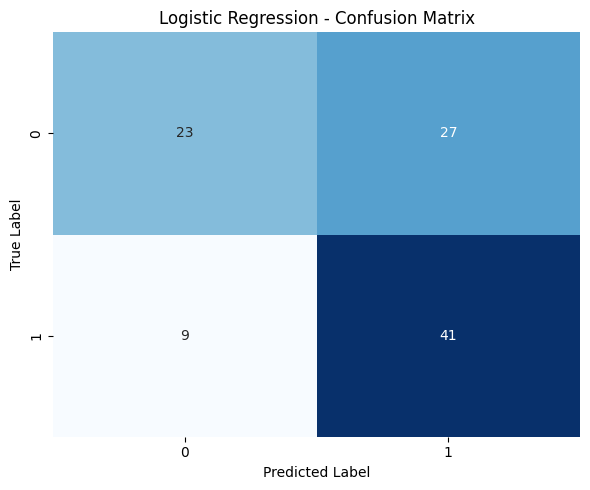

In [ ]:
y_pred_logreg = best_log_reg.predict(X_test_scaled)
plot_confusion_matrix(y_test, y_pred_logreg, "Logistic Regression")


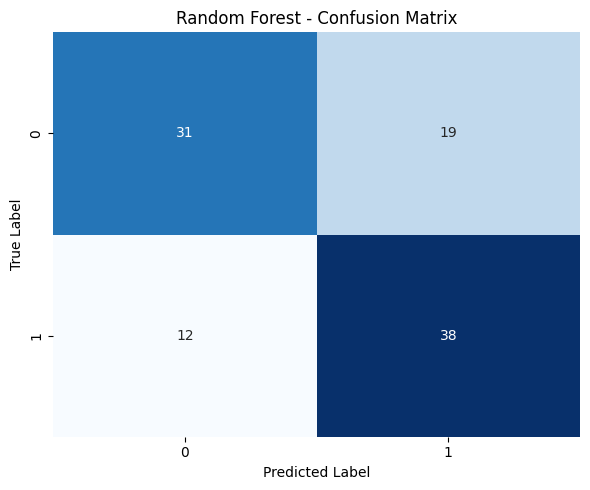

In [ ]:
y_pred_rf = best_rf.predict(X_test_scaled)
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")


bunları da değrlendir